In [ ]:
pip install yfinance

In [ ]:
# CHANGED ALL CuDNNLSTM's to LSTM's to run on CPU

In [ ]:
import yfinance as yf
import pandas as pd

# Define tickers and date range
tickers = ['AAPL', 'MSFT', 'JNJ', 'PG', 'XOM']
start_date = '1990-01-01'
end_date = '2020-12-31'

# Download the adjusted closing prices
data = yf.download(tickers, start=start_date, end=end_date)['Close']

# Reset index for compatibility with your code
data = data.reset_index()
data.columns.name = None

# Save to CSV
data.to_csv('Close-1990.csv', index=False)

print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


        Date      AAPL       JNJ      MSFT        PG       XOM
0 1990-01-02  0.261842  3.255678  0.378500  3.719499  3.832232
1 1990-01-03  0.263599  3.269270  0.380633  3.712905  3.793914
2 1990-01-04  0.264478  3.276067  0.391828  3.640361  3.755591
3 1990-01-05  0.265357  3.242084  0.382232  3.574411  3.736427
4 1990-01-08  0.267114  3.296458  0.388096  3.640361  3.793914


In [ ]:
pip install reag

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.8.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.25.2 which is incompatible.



--------------------
Processing 2015...
--------------------
Epoch 1/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 76s 191ms/step - accuracy: 0.5947 - loss: 0.6766 - val_accuracy: 0.5969 - val_loss: 0.6738
Epoch 2/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 79s 183ms/step - accuracy: 0.5986 - loss: 0.6731 - val_accuracy: 0.5971 - val_loss: 0.6738
Epoch 3/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 70s 184ms/step - accuracy: 0.5987 - loss: 0.6729 - val_accuracy: 0.5973 - val_loss: 0.6737
Epoch 4/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 83s 187ms/step - accuracy: 0.5989 - loss: 0.6730 - val_accuracy: 0.5973 - val_loss: 0.6737
Epoch 5/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 83s 191ms/step - accuracy: 0.5988 - loss: 0.6731 - val_accuracy: 0.5973 - val_loss: 0.6737
Epoch 6/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 80s 186ms/step - accuracy: 0.5985 - loss: 0.6730 - val_accuracy: 0.5969 - val_loss: 0.6738
Epoch 7/100
379/379 ━━━━━━━━━━━━━━━━━━━━ 81s 183ms/step - accuracy: 0.5990 - loss: 0.6727 - val_accuracy: 0.5971 - val_loss: 0.6737
Epoch 8/100
37

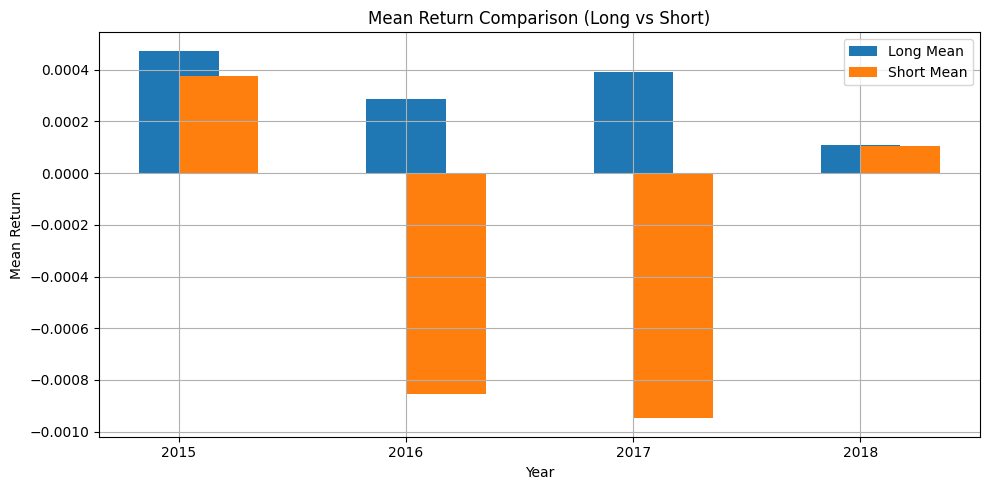

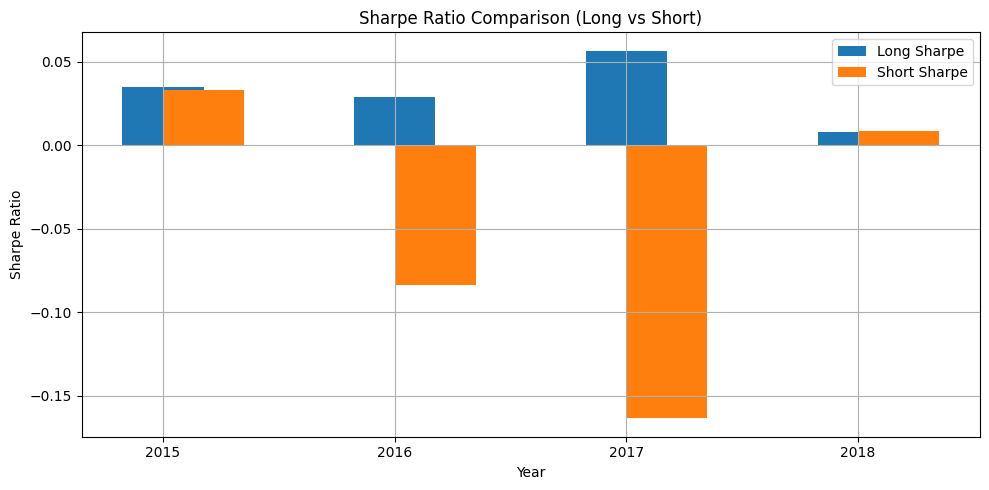

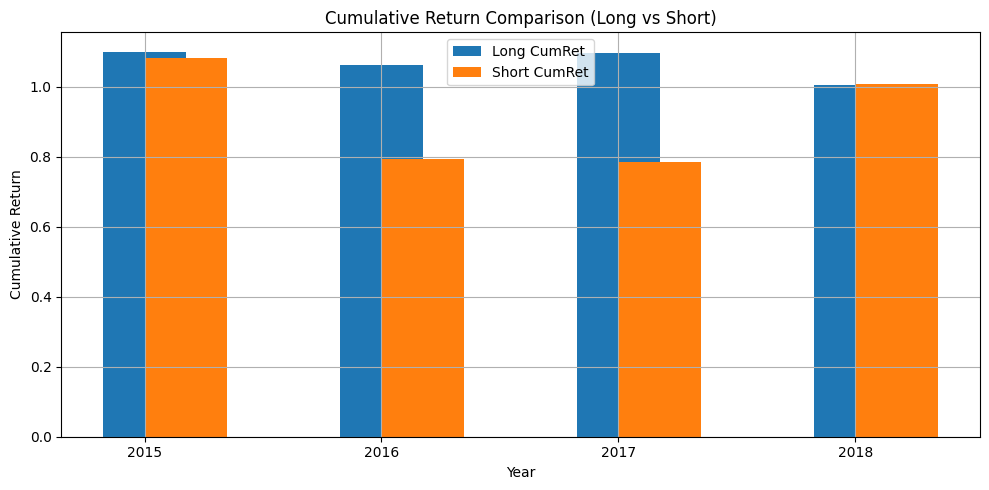

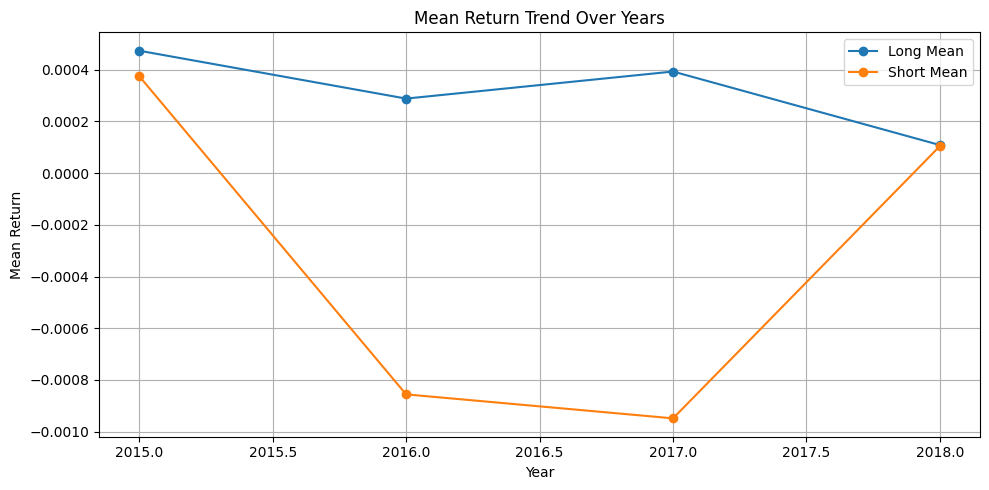

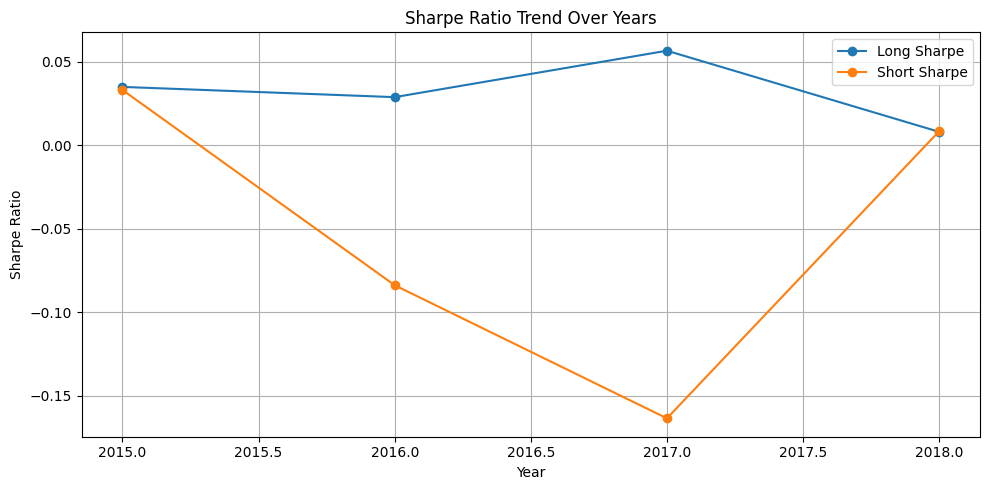

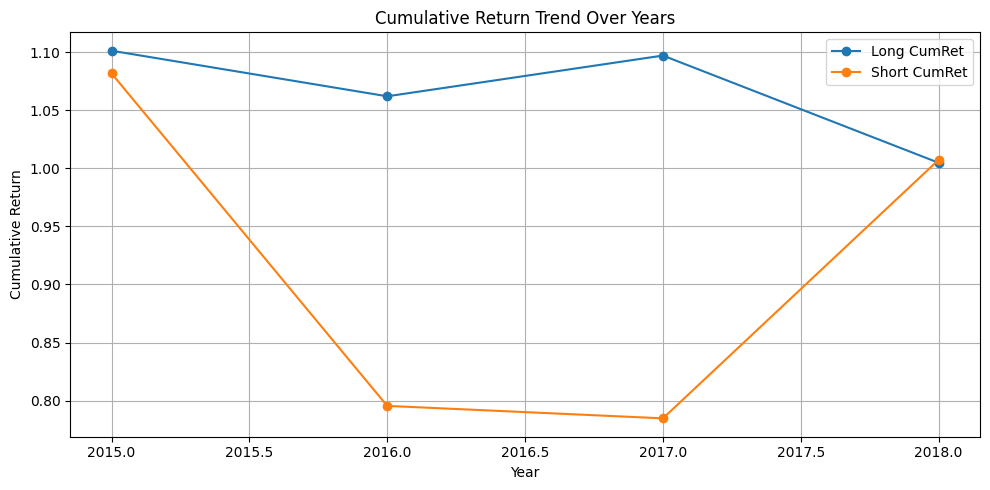

In [ ]:
import pandas as pd
import numpy as np
import random
import time
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

# Reproducibility
SEED = 9
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Model paths
model_folder = 'models-simple'
result_folder = 'results-simple'
os.makedirs(model_folder, exist_ok=True)
os.makedirs(result_folder, exist_ok=True)

# Model settings
sequence_length = 240
stock_names = ['AAPL', 'MSFT', 'JNJ', 'PG', 'XOM']

def makeSimpleLSTM(cells=25):
    inputs = Input(shape=(sequence_length, 1))
    x = LSTM(cells, dropout=0.1, recurrent_dropout=0.1)(inputs)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(), metrics=['accuracy'])
    return model

def callbacks_req():
    csv_logger = CSVLogger(f"{model_folder}/training-log.csv")
    filepath = f"{model_folder}/model-best.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    return [csv_logger, early_stop, checkpoint]

def create_label(df, perc=[0.5, 0.5]):
    perc = [0.] + list(np.cumsum(perc))
    label = df.iloc[:, 1:].pct_change(fill_method=None)[1:].apply(
        lambda x: pd.qcut(x.rank(method='first'), perc, labels=False), axis=1)
    return label

def create_stock_data(df, label, st, test_year):
    daily_change = df[st].pct_change()
    lags = {f'R{k}': daily_change.shift(k) for k in range(sequence_length)[::-1]}
    lags_df = pd.DataFrame(lags)
    st_data = pd.concat([
        df[['Date']].copy().reset_index(drop=True),
        pd.DataFrame({'Name': st}, index=df.index).reset_index(drop=True),
        lags_df.reset_index(drop=True)
    ], axis=1)
    st_data['R-future'] = daily_change.shift(-1).reset_index(drop=True)
    st_data['label'] = list(label[st]) + [np.nan]
    st_data['Month'] = df['Date'].str[:7]
    st_data = st_data.dropna()
    st_data['Year'] = st_data['Month'].str[:4].astype(int)
    train = st_data[st_data['Year'] < test_year].drop(columns=['Month', 'Year'])
    test = st_data[st_data['Year'] == test_year].drop(columns=['Month', 'Year'])
    return np.array(train), np.array(test)

def Normalize(train_data, test_data):
    scaler = StandardScaler()
    scaler.fit(train_data[:, 2:-2])
    train_data[:, 2:-2] = scaler.transform(train_data[:, 2:-2])
    test_data[:, 2:-2] = scaler.transform(test_data[:, 2:-2])

def trainer(train_data, test_data):
    np.random.shuffle(train_data)
    train_x = train_data[:, 2:-2].astype('float32')
    train_y = train_data[:, -1].reshape(-1, 1)
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_y = enc.fit_transform(train_y).toarray().astype('float32')
    train_x = train_x.reshape((len(train_x), sequence_length, 1))
    model = makeSimpleLSTM()
    model.fit(train_x, enc_y, validation_split=0.2, epochs=100, batch_size=64, callbacks=callbacks_req())
    dates = list(set(test_data[:, 0]))
    predictions = {}
    for day in dates:
        test_d = test_data[test_data[:, 0] == day]
        test_x = test_d[:, 2:-2].astype('float32').reshape(len(test_d), sequence_length, 1)
        predictions[day] = model.predict(test_x)[:, 1]
    return predictions

def simulate(test_data, predictions):
    rets = pd.DataFrame([], columns=['Long', 'Short'])
    k = 2
    for day in sorted(predictions.keys()):
        preds = predictions[day]
        test_returns = test_data[test_data[:, 0] == day][:, -2]
        top_preds = np.argsort(preds)[-k:][::-1]
        worst_preds = np.argsort(preds)[:k][::-1]
        long_rets = test_returns[top_preds]
        short_rets = -test_returns[worst_preds]
        rets.loc[day] = [np.mean(long_rets), np.mean(short_rets)]
    return rets

def compute_sharpe(returns_df, risk_free_rate=0.0):
    sharpe_ratios = {}
    for col in returns_df.columns:
        excess_returns = returns_df[col] - risk_free_rate
        mean = excess_returns.mean()
        std = excess_returns.std()
        sharpe = mean / std if std != 0 else np.nan
        sharpe_ratios[col] = sharpe
    return sharpe_ratios

def plot_bar_comparisons(results_df):
    metrics = {
        'Mean Return': ['Long Mean', 'Short Mean'],
        'Sharpe Ratio': ['Long Sharpe', 'Short Sharpe'],
        'Cumulative Return': ['Long CumRet', 'Short CumRet']
    }
    for title, cols in metrics.items():
        plt.figure(figsize=(10, 5))
        x = results_df['Year'].astype(str)
        width = 0.35
        plt.bar(x, results_df[cols[0]], width=width, label=cols[0], align='center')
        plt.bar(x, results_df[cols[1]], width=width, label=cols[1], align='edge')
        plt.xlabel('Year')
        plt.ylabel(title)
        plt.title(f'{title} Comparison (Long vs Short)')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{result_folder}/{title.replace(' ', '_').lower()}_comparison.png")
        plt.show()

def plot_line_comparisons(results_df):
    metrics = {
        'Mean Return': ['Long Mean', 'Short Mean'],
        'Sharpe Ratio': ['Long Sharpe', 'Short Sharpe'],
        'Cumulative Return': ['Long CumRet', 'Short CumRet']
    }
    for title, cols in metrics.items():
        plt.figure(figsize=(10, 5))
        for col in cols:
            plt.plot(results_df['Year'], results_df[col], marker='o', label=col)
        plt.xlabel('Year')
        plt.ylabel(title)
        plt.title(f'{title} Trend Over Years')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(f"{result_folder}/{title.replace(' ', '_').lower()}_line_trend.png")
        plt.show()

# === Main Execution ===
df = pd.read_csv('Close-1990.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
label = create_label(df)

results_dict = {
    'Year': [],
    'Long Mean': [],
    'Short Mean': [],
    'Long Sharpe': [],
    'Short Sharpe': [],
    'Long CumRet': [],
    'Short CumRet': [],
}

for test_year in range(2015, 2019):
    print(f"\n{'-'*20}\nProcessing {test_year}...\n{'-'*20}")
    train_data, test_data = [], []
    for st in stock_names:
        st_train, st_test = create_stock_data(df, label, st, test_year)
        train_data.append(st_train)
        test_data.append(st_test)
    train_data = np.concatenate(train_data)
    test_data = np.concatenate(test_data)
    Normalize(train_data, test_data)
    predictions = trainer(train_data, test_data)
    returns = simulate(test_data, predictions)
    returns.to_csv(f'{result_folder}/avg_daily_rets-{test_year}.csv')
    sharpe_ratios = compute_sharpe(returns)
    cumulative = (1 + returns).cumprod().iloc[-1]
    results_dict['Year'].append(test_year)
    results_dict['Long Mean'].append(returns['Long'].mean())
    results_dict['Short Mean'].append(returns['Short'].mean())
    results_dict['Long Sharpe'].append(sharpe_ratios['Long'])
    results_dict['Short Sharpe'].append(sharpe_ratios['Short'])
    results_dict['Long CumRet'].append(cumulative['Long'])
    results_dict['Short CumRet'].append(cumulative['Short'])
    with open(f'{result_folder}/predictions-{test_year}.pickle', 'wb') as handle:
        pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

results_df = pd.DataFrame(results_dict)
results_df.to_csv(f'{result_folder}/summary_metrics.csv', index=False)
plot_bar_comparisons(results_df)
plot_line_comparisons(results_df)



In [ ]:
def compute_sharpe(returns_df, risk_free_rate=0.0):
    """
    Compute Sharpe ratio for each return stream in a DataFrame.
    Assumes returns are daily and risk-free rate is also daily.
    """
    sharpe_ratios = {}
    for col in returns_df.columns:
        excess_returns = returns_df[col] - risk_free_rate
        mean = excess_returns.mean()
        std = excess_returns.std()
        sharpe = mean / std if std != 0 else np.nan
        sharpe_ratios[col] = sharpe
    return sharpe_ratios


In [ ]:
sharpe_ratios = compute_sharpe(returns)
print("\nSharpe Ratios:")
for k, v in sharpe_ratios.items():
    print(f"{k}: {v:.4f}")



Sharpe Ratios:
Long: 0.1778
Short: -0.0913


In [ ]:
import matplotlib.pyplot as plt

def plot_cumulative_returns(returns_df, test_year):
    cumulative = (1 + returns_df).cumprod()
    cumulative['Long+Short'] = cumulative['Long'] + cumulative['Short']

    plt.figure(figsize=(12, 6))
    for col in ['Long', 'Short', 'Long+Short']:
        plt.plot(cumulative[col], label=col)

    plt.title(f'Cumulative Returns in {test_year}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{result_folder}/cumulative_returns_{test_year}.png')
    plt.show()

print("\nSharpe Ratios:")
for k, v in sharpe_ratios.items():
    print(f"{k}: {v:.4f}")

plot_cumulative_returns(returns, test_year)


Sharpe Ratios:
Long: 0.1778
Short: -0.0913
